In [ ]:
!pip -q install pandas numpy scikit-learn sentence-transformers hdbscan umap-learn matplotlib tqdm

import os
import re
import json
import gzip
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import umap
import hdbscan
from sentence_transformers import SentenceTransformer

In [3]:
from google.colab import drive
drive.mount("/content/drive")     # mounting drive

OUT_DIR = "/content/drive/MyDrive/price2/price_csv" #path to save embeddings and outputs
os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

CSV_PATH = "/content/electronics_product.csv"
print("CSV_PATH:", CSV_PATH)

Mounted at /content/drive
OUT_DIR: /content/drive/MyDrive/price2/price_csv
CSV_PATH: /content/electronics_product.csv


In [4]:
df_raw = pd.read_csv(CSV_PATH)
print("Rows, Cols:", df_raw.shape)
df_raw.head(5)    #displaying firat 5 rows


Rows, Cols: (9600, 10)


,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965,"₹10,999","₹18,999"
1,1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,"113,956","₹18,999","₹19,999"
2,2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,"90,304","₹1,999","₹2,299"
3,3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yj...,https://www.amazon.in/Samsung-Mystique-Storage...,4.1,"24,863","₹15,999","₹24,999"
4,4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUI...,https://www.amazon.in/OnePlus-Nord-Black-128GB...,4.3,"113,956","₹18,999","₹19,999"


In [5]:
df_raw.info()  #checking the schema


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      9600 non-null   int64 
 1   name            9600 non-null   object
 2   main_category   9600 non-null   object
 3   sub_category    9600 non-null   object
 4   image           9600 non-null   object
 5   link            9600 non-null   object
 6   ratings         9505 non-null   object
 7   no_of_ratings   9505 non-null   object
 8   discount_price  9116 non-null   object
 9   actual_price    9530 non-null   object
dtypes: int64(1), object(9)
memory usage: 750.1+ KB


In [6]:
missing = df_raw.isna().sum().sort_values(ascending=False)
(missing / len(df_raw) * 100).round(2).head(20)  #computing missing values to decide whta to drop andwhat to impute


,0
discount_price,5.04
ratings,0.99
no_of_ratings,0.99
actual_price,0.73
name,0.00
Unnamed: 0,0.00
link,0.00
image,0.00
sub_category,0.00
main_category,0.00


In [7]:
def clean_text(x):    #stripping html/noisy whitespaces
    if pd.isna(x):
        return ""
    x = str(x).lower().strip()
    x = re.sub(r"<.*?>", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x
#converting strings to float
def parse_price(x):
      if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    s = str(x).strip()
    if not s:
        return np.nan

    # removing common words
    s_low = s.lower()
    for bad in ["see price", "unavailable", "currently unavailable", "add to cart", "free"]:
        if bad in s_low:
            return np.nan

    # keeping digits and decimal points; while removing commas
    s = s.replace(",", "")
    nums = re.findall(r"\d+(?:\.\d+)?", s)
    if not nums:
        return np.nan
    vals = [float(n) for n in nums]
    return min(vals)  # if a range, take lower bound


In [8]:
df = df_raw.copy()

# standardizing expected column names
expected = ["name","main_category","sub_category","image","link","ratings","no_of_ratings","discount_price","actual_price"]
for c in expected:
    if c not in df.columns:
        df[c] = np.nan

# cleaning text columns
df["name_clean"] = df["name"].apply(clean_text)
df["maincat_clean"] = df["main_category"].apply(clean_text)
df["subcat_clean"] = df["sub_category"].apply(clean_text)

# numeric columns
df["ratings"] = pd.to_numeric(df["ratings"], errors="coerce")
df["no_of_ratings"] = pd.to_numeric(df["no_of_ratings"], errors="coerce")

# parse prices
df["discount_price_num"] = df["discount_price"].apply(parse_price)
df["actual_price_num"] = df["actual_price"].apply(parse_price)

# basic filtering: must have name + target price for evaluation
df = df[df["name_clean"].str.len() > 0].copy()

print("After name filter:", len(df))
print("Usable actual_price:", df["actual_price_num"].notna().mean() * 100, "%")
df.head(3)


After name filter: 9600
Usable actual_price: 99.27083333333333 %


,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,name_clean,maincat_clean,subcat_clean,discount_price_num,actual_price_num
0,0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965.0,"₹10,999","₹18,999","redmi 10 power (power black, 8gb ram, 128gb st...","tv, audio & cameras",all electronics,10999.0,18999.0
1,1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,NaN,"₹18,999","₹19,999","oneplus nord ce 2 lite 5g (blue tide, 6gb ram,...","tv, audio & cameras",all electronics,18999.0,19999.0
2,2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,NaN,"₹1,999","₹2,299",oneplus bullets z2 bluetooth wireless in ear e...,"tv, audio & cameras",all electronics,1999.0,2299.0


CSV appears to have a single main_category and sub_category.Checking if it's true.

In [11]:
print("main_category unique:", df_raw["main_category"].nunique(dropna=False))
print("sub_category unique:", df_raw["sub_category"].nunique(dropna=False))

print("\nTop main_category values:\n", df_raw["main_category"].value_counts(dropna=False).head(10))
print("\nTop sub_category values:\n", df_raw["sub_category"].value_counts(dropna=False).head(10))


main_category unique: 1
sub_category unique: 1

Top main_category values:
 main_category
tv, audio & cameras    9600
Name: count, dtype: int64

Top sub_category values:
 sub_category
All Electronics    9600
Name: count, dtype: int64


Plotting to show that there is only one min category.
Plotting log(1+price) to help visualize the spread of prices.

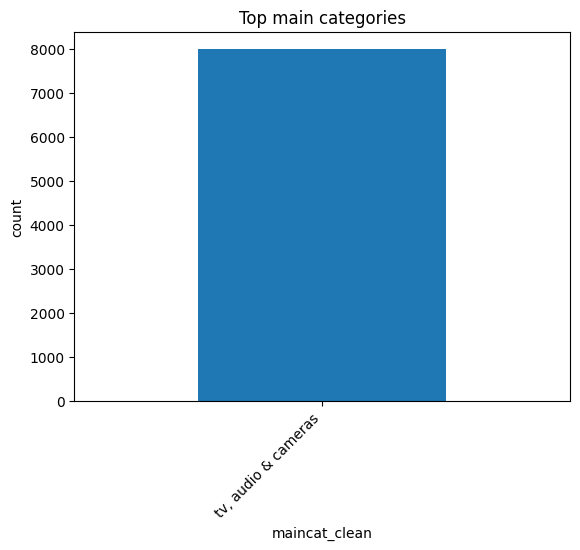

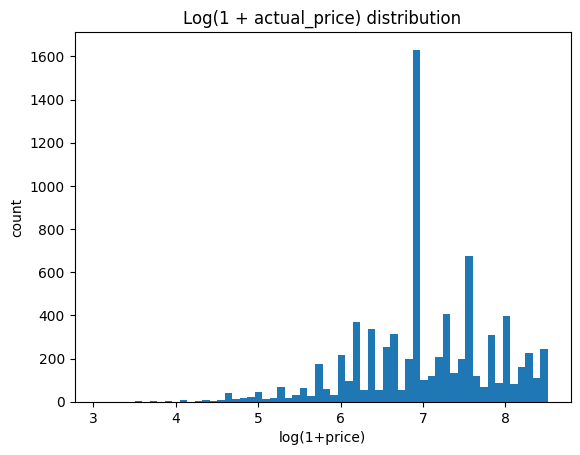

In [10]:
priced = df.dropna(subset=["actual_price_num"]).copy()
plt.figure()
plt.hist(np.log1p(priced["actual_price_num"]), bins=60)
plt.title("Log(1 + actual_price) distribution")
plt.xlabel("log(1+price)")
plt.ylabel("count")
plt.show()


In [12]:
df["text_for_embed"] = df["name_clean"]  #embedding the clened product name


As the category fiels in the CSV are not informative as they have an unique value,we create a heuristic label from product names for analysis and plots and cluster intrepetation.

In [13]:
KEYWORDS = {
    "tv": [" tv ", "television", "oled", "qled", "uhd", "4k tv", "smart tv"],
    "headphones": ["headphone", "earbud", "earphone", "tws", "neckband"],
    "speaker": ["speaker", "soundbar", "subwoofer", "home theater"],
    "camera": ["camera", "dslr", "mirrorless", "lens", "gopro"],
    "microphone": ["microphone", "mic", "condenser", "wireless mic"],
    "projector": ["projector"],
    "streaming": ["fire stick", "chromecast", "streaming", "roku"],
    "accessory": ["cable", "adapter", "charger", "battery", "case", "mount", "tripod", "stand"],
}    #heuristic labels

def weak_category(name):
    s = " " + str(name).lower() + " "
    for k, words in KEYWORDS.items():
        if any(w in s for w in words):
            return k
    return "other"

df["weak_cat"] = df["name"].apply(weak_category)
df["weak_cat"].value_counts().head(15)


,count
weak_cat,
other,3205
accessory,2623
headphones,893
camera,516
microphone,373
tv,177
speaker,177
projector,11
streaming,6


Bar chat to see the compsosition by heuristic level

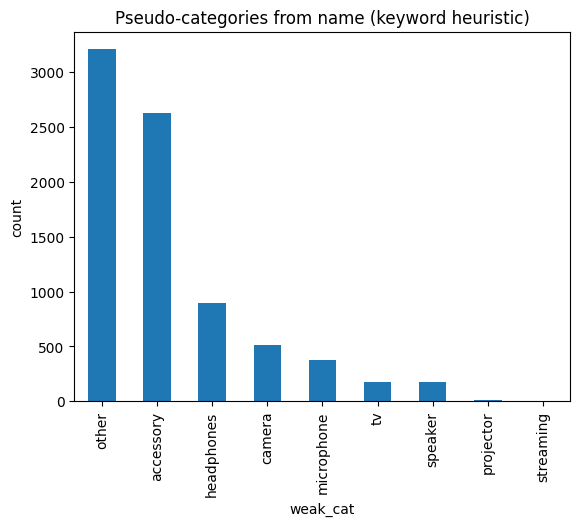

In [14]:
import matplotlib.pyplot as plt
top = df["weak_cat"].value_counts().head(10)
plt.figure()
top.plot(kind="bar")
plt.title("Pseudo-categories from name (keyword heuristic)")
plt.ylabel("count")
plt.show()


In [17]:
CSV_PATH = "/content/drive/MyDrive/price2/electronics_product.csv"
print("CSV_PATH:", CSV_PATH)

CSV_PATH: /content/drive/MyDrive/price2/electronics_product.csv


# **Feature engineering.**

In [31]:
df["text_for_embed"] = df["name_clean"]

# numeric features (filled)
df["ratings_f"] = df["ratings"].fillna(df["ratings"].median())
df["no_ratings_f"] = df["no_of_ratings"].fillna(0)

# better scaling for counts
df["log_no_ratings"] = np.log1p(df["no_ratings_f"])

# discount ratio (if both present)
ratio = np.where(
    df["discount_price_num"].notna() & df["actual_price_num"].notna() & (df["actual_price_num"] > 0),
    df["discount_price_num"] / df["actual_price_num"],
    np.nan
)
df["disc_ratio"] = pd.Series(ratio).fillna(pd.Series(ratio).median())


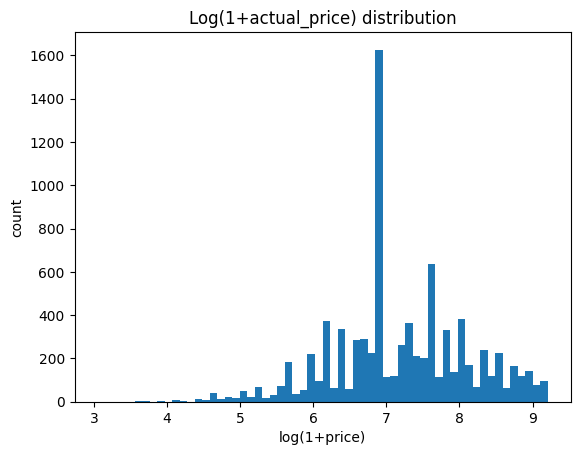

In [32]:
priced = df.dropna(subset=["actual_price_num"])
plt.figure()
plt.hist(np.log1p(priced["actual_price_num"]), bins=60)
plt.title("Log(1+actual_price) distribution")
plt.xlabel("log(1+price)")
plt.ylabel("count")
plt.show()


We embed text_for_embed using all-MiniLM-L6-V2 and cache to disk so reruns are fast

In [33]:
from sentence_transformers import SentenceTransformer

CACHE_DIR = "./cache_csv"      #cache
os.makedirs(CACHE_DIR, exist_ok=True)

E_PATH = os.path.join(CACHE_DIR, "E.npy")

if os.path.exists(E_PATH):
    E = np.load(E_PATH)
    print("Loaded embeddings:", E.shape)
else:
    model = SentenceTransformer("all-MiniLM-L6-v2")
    E = model.encode(
        df["text_for_embed"].tolist(),
        batch_size=128,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    np.save(E_PATH, E)
    print("Saved embeddings:", E.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

Saved embeddings: (8661, 384)


In [38]:
import numpy as np

num_cols = ["ratings_f","log_no_ratings","disc_ratio"]
print(df[num_cols].isna().sum())


print("Any inf in disc_ratio?", np.isinf(df["disc_ratio"]).sum())
#verify that we dont have any NaNs/infs

ratings_f           0
log_no_ratings      0
disc_ratio        854
dtype: int64
Any inf in disc_ratio? 0


**Numeric Feature Engineering**

In [39]:
# ratings
df["ratings_f"] = pd.to_numeric(df["ratings"], errors="coerce")
df["ratings_f"] = df["ratings_f"].fillna(df["ratings_f"].median())
if pd.isna(df["ratings_f"].median()):  # edge case: all missing
    df["ratings_f"] = df["ratings_f"].fillna(0)

# number of ratings
df["no_ratings_f"] = pd.to_numeric(df["no_of_ratings"], errors="coerce").fillna(0)
df["no_ratings_f"] = df["no_ratings_f"].clip(lower=0)
df["log_no_ratings"] = np.log1p(df["no_ratings_f"])

# discount ratio
dp = df["discount_price_num"]
ap = df["actual_price_num"]

ratio = np.where(
    dp.notna() & ap.notna() & (ap > 0),
    dp / ap,
    np.nan
)

# Fill ratio with a sensible fallback:
# If we have enough valid ratios we use median
# Otherwise we set to 1.0 (no discount signal)
ratio_series = pd.Series(ratio)
if ratio_series.notna().sum() >= 50:
    fill_val = float(ratio_series.median())
else:
    fill_val = 1.0

df["disc_ratio"] = ratio_series.fillna(fill_val)

# Final safety: replacing inf/-inf and remaining NaNs
for c in ["ratings_f","log_no_ratings","disc_ratio"]:
    df[c] = df[c].replace([np.inf, -np.inf], np.nan).fillna(0)

df[["ratings_f","log_no_ratings","disc_ratio"]].isna().sum()


,0
ratings_f,0
log_no_ratings,0
disc_ratio,0


**Building Final Matrix X**


In [40]:
from sklearn.preprocessing import StandardScaler
import numpy as np

num = df[["ratings_f","log_no_ratings","disc_ratio"]].values
num_scaled = StandardScaler().fit_transform(num)

X = np.hstack([E, num_scaled])


print("Any NaN in X?", np.isnan(X).any())
print("Any inf in X?", np.isinf(X).any())
print("X shape:", X.shape)


Any NaN in X? False
Any inf in X? False
X shape: (8661, 387)


In [41]:
from sklearn.preprocessing import StandardScaler

num = df[["ratings_f","log_no_ratings","disc_ratio"]].values
num_scaled = StandardScaler().fit_transform(num)

X = np.hstack([E, num_scaled])  #rerunning after a few edits
print("X shape:", X.shape)


X shape: (8661, 387)


## **KMeans**
we try several kvalues to compute which one to use
Silhouette-higher the better
Davies Boulding - lower the better

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

Ks = [8, 10, 12, 15, 20, 30]

rng = np.random.default_rng(42)
idx = rng.choice(X.shape[0], size=min(6000, X.shape[0]), replace=False)

k_results = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_km = km.fit_predict(X)
    sil = silhouette_score(X[idx], labels_km[idx])
    dbi = davies_bouldin_score(X[idx], labels_km[idx])
    k_results.append((k, sil, dbi))
    print("K=", k, "sil=", sil, "db=", dbi)

best_k = max(k_results, key=lambda t: t[1])[0]
print("Best K by sampled silhouette:", best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_km = km.fit_predict(X)


K= 8 sil= 0.15828647710802898 db= 1.6122761890957285
K= 10 sil= 0.15449247598801244 db= 1.58699280211921
K= 12 sil= 0.15284863094660053 db= 1.5641519953582632
K= 15 sil= 0.12659395576987353 db= 1.7314556347736423
K= 20 sil= 0.11001235311850784 db= 1.8298139546546843
K= 30 sil= 0.09019108014373811 db= 2.036541072987974
Best K by sampled silhouette: 8


**UMAP + HDBSCAN**
as hdbscan is sensitive to parameters we reduce with UMAP for faster learning.

Aldso we score using silhouette/DB on a sample

In [43]:
import umap, hdbscan

U10_PATH = os.path.join(CACHE_DIR, "U10.npy")
if os.path.exists(U10_PATH):
    U10 = np.load(U10_PATH)
    print("Loaded U10:", U10.shape)
else:
    U10 = umap.UMAP(
        n_neighbors=30, min_dist=0.1, n_components=10,
        metric="cosine", random_state=42
    ).fit_transform(E)
    np.save(U10_PATH, U10)
    print("Saved U10:", U10.shape)

def eval_labels_fast(X_small, labels, sample_size=6000, seed=42):
    mask = labels != -1
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_rate = float((labels == -1).mean())

    sil = None
    dbi = None
    if mask.sum() > 500 and n_clusters > 1:
        idx = np.where(mask)[0]
        rng = np.random.default_rng(seed)
        if len(idx) > sample_size:
            idx = rng.choice(idx, size=sample_size, replace=False)
        sil = silhouette_score(X_small[idx], labels[idx])
        dbi = davies_bouldin_score(X_small[idx], labels[idx])

    return n_clusters, noise_rate, sil, dbi

mcs_list = [20, 30, 50, 80]
ms_list  = [5, 10, 15]

grid = []
for mcs in mcs_list:
    for ms in ms_list:
        hd = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        labels = hd.fit_predict(U10)
        ncl, noise, sil, dbi = eval_labels_fast(U10, labels)
        grid.append((mcs, ms, ncl, noise, sil, dbi))
        print("mcs=", mcs, "ms=", ms, "clusters=", ncl, "noise=", round(noise,3), "sil=", sil)

grid_df = pd.DataFrame(grid, columns=["min_cluster_size","min_samples","n_clusters","noise_rate","silhouette","db_index"])
grid_df.sort_values(["silhouette","noise_rate"], ascending=[False, True]).head(10)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved U10: (8661, 10)
mcs= 20 ms= 5 clusters= 133 noise= 0.161 sil= 0.6405553
mcs= 20 ms= 10 clusters= 107 noise= 0.162 sil= 0.66481614
mcs= 20 ms= 15 clusters= 96 noise= 0.158 sil= 0.66655666
mcs= 30 ms= 5 clusters= 83 noise= 0.133 sil= 0.63033485
mcs= 30 ms= 10 clusters= 65 noise= 0.091 sil= 0.606329
mcs= 30 ms= 15 clusters= 68 noise= 0.131 sil= 0.6468219
mcs= 50 ms= 5 clusters= 50 noise= 0.101 sil= 0.5732764
mcs= 50 ms= 10 clusters= 45 noise= 0.052 sil= 0.59067804
mcs= 50 ms= 15 clusters= 42 noise= 0.063 sil= 0.6192368
mcs= 80 ms= 5 clusters= 29 noise= 0.057 sil= 0.57298017
mcs= 80 ms= 10 clusters= 31 noise= 0.093 sil= 0.6044505
mcs= 80 ms= 15 clusters= 26 noise= 0.048 sil= 0.60359406


,min_cluster_size,min_samples,n_clusters,noise_rate,silhouette,db_index
2,20,15,96,0.158296,0.666557,0.390624
1,20,10,107,0.161529,0.664816,0.417889
5,30,15,68,0.130585,0.646822,0.404132
0,20,5,133,0.161182,0.640555,0.508899
3,30,5,83,0.132779,0.630335,0.460832
8,50,15,42,0.062579,0.619237,0.466150
4,30,10,65,0.090752,0.606329,0.434790
10,80,10,31,0.092599,0.604451,0.497387
11,80,15,26,0.048262,0.603594,0.506971
7,50,10,45,0.052188,0.590678,0.464106


Fitting HDBSCAN with good parameters

In [44]:
best = grid_df.sort_values(["silhouette","noise_rate"], ascending=[False, True]).iloc[0]
best_mcs = int(best["min_cluster_size"])
best_ms  = int(best["min_samples"])
print("Chosen HDBSCAN params:", best_mcs, best_ms)

hd = hdbscan.HDBSCAN(min_cluster_size=best_mcs, min_samples=best_ms)
labels_hd = hd.fit_predict(U10)

print("HDBSCAN clusters:", len(set(labels_hd)) - (1 if -1 in labels_hd else 0))
print("Noise rate:", (labels_hd == -1).mean())


Chosen HDBSCAN params: 20 15
HDBSCAN clusters: 96
Noise rate: 0.15829580879806027


# **Visualiing clusters across kmeans and HDBSCAN**


KMeans struggles because it assumes equal-sized, clusters, which does not match the  structure of the embedding space

HDBSCAN captures the  density-based structure and correctly identifies noise, making it more appropriate for semantic embedding spaces.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


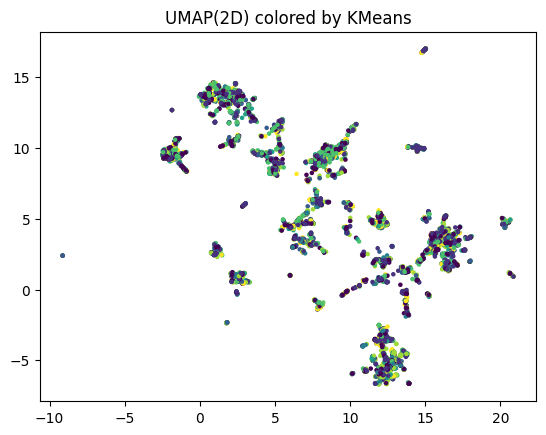

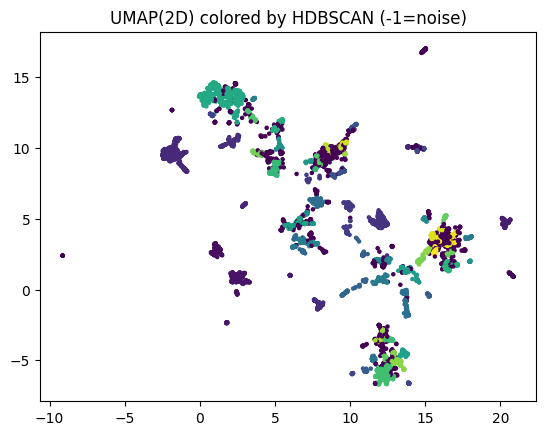

In [45]:
U2 = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric="cosine", random_state=42).fit_transform(E)

plt.figure()
plt.scatter(U2[:,0], U2[:,1], s=5, c=labels_km)
plt.title("UMAP(2D) colored by KMeans")
plt.show()

plt.figure()
plt.scatter(U2[:,0], U2[:,1], s=5, c=labels_hd)
plt.title("UMAP(2D) colored by HDBSCAN (-1=noise)")
plt.show()


Evalusting based on 3 baselines -Global median vs cluster median (kmeans , hdbscan)

In [46]:
df_out = df.copy()
df_out["km_cluster"] = labels_km
df_out["hd_cluster"] = labels_hd

d = df_out.dropna(subset=["actual_price_num"]).copy()

# Baseline
global_med = d["actual_price_num"].median()
baseline_mae = float(np.mean(np.abs(d["actual_price_num"] - global_med)))
print("Global median baseline MAE:", baseline_mae, "| global median:", global_med)

def cluster_median_mae(df_in, label_col, drop_noise=False, min_n=20):
    t = df_in.copy()
    if drop_noise:
        t = t[t[label_col] != -1].copy()

    counts = t[label_col].value_counts()
    good = counts[counts >= min_n].index
    t = t[t[label_col].isin(good)].copy()

    med = t.groupby(label_col)["actual_price_num"].median()
    pred = t[label_col].map(med)
    mae = float(np.mean(np.abs(t["actual_price_num"] - pred)))
    return mae, len(t), len(good)

mae_km, n_km, c_km = cluster_median_mae(d, "km_cluster", drop_noise=False)
mae_hd, n_hd, c_hd = cluster_median_mae(d, "hd_cluster", drop_noise=True)

print("KMeans cluster-median MAE:", mae_km, "rows:", n_km, "clusters:", c_km)
print("HDBSCAN cluster-median MAE:", mae_hd, "rows:", n_hd, "clusters:", c_hd)


Global median baseline MAE: 1286.1009928995459 | global median: 1099.0
KMeans cluster-median MAE: 1271.4558991968338 rows: 8591 clusters: 8
HDBSCAN cluster-median MAE: 887.8380509060727 rows: 7229 clusters: 96


In [49]:
bins_inr = [0, 200, 500, 1000, 1500, 2000, 3000, 5000, 8000, 12000, 20000]
d2 = d[d["hd_cluster"] != -1].copy()
med = d2.groupby("hd_cluster")["actual_price_num"].median()
d2["pred"] = d2["hd_cluster"].map(med)
d2["abs_err"] = (d2["actual_price_num"] - d2["pred"]).abs()
d2["ape"] = d2["abs_err"] / d2["actual_price_num"].clip(lower=1)  # % error

d2["price_bin"] = pd.cut(d2["actual_price_num"], bins=bins_inr)

summary_inr = d2.groupby("price_bin").agg(
    n=("actual_price_num","count"),
    median_price=("actual_price_num","median"),
    mae=("abs_err","mean"),
    mape=("ape","mean")
).reset_index()

summary_inr


/tmp/ipython-input-1725674490.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_inr = d2.groupby("price_bin").agg(


,price_bin,n,median_price,mae,mape
0,"(0, 200]",166,150.0,368.060241,3.294765
1,"(200, 500]",865,399.0,565.320335,1.427651
2,"(500, 1000]",2477,999.0,369.390666,0.471656
3,"(1000, 1500]",730,1378.0,621.771918,0.466473
4,"(1500, 2000]",860,1999.0,793.146512,0.421787
5,"(2000, 3000]",802,2599.0,1025.030549,0.383802
6,"(3000, 5000]",728,3999.0,1574.531593,0.376777
7,"(5000, 8000]",458,6990.0,2716.029476,0.407141
8,"(8000, 12000]",143,9499.0,4229.552448,0.452037
9,"(12000, 20000]",0,NaN,NaN,NaN


Top HDBSCAN clusters
As we look it to many clusters most of the similar accessories with sane price ranges are clustered together ex 57 has phone cases mostly, cluster 66 has headphones and microphones with same price ranges etc

In [48]:
top_clusters = [c for c in pd.Series(labels_hd).value_counts().index.tolist() if c != -1][:5]

for c in top_clusters:
    sub = df_out[df_out["hd_cluster"] == c].copy()
    print("\n====================")
    print("Cluster:", c, "size:", len(sub))
    print("weak_cat mix:\n", sub["weak_cat"].value_counts().head(8))
    display(sub[["name","weak_cat","ratings","no_of_ratings","discount_price","actual_price"]].head(10))



Cluster: 57 size: 728
weak_cat mix:
 weak_cat
accessory     449
other         136
camera        134
microphone      7
headphones      2
Name: count, dtype: int64


,name,weak_cat,ratings,no_of_ratings,discount_price,actual_price
326,Amozo Ultra Hybrid Camera and Drop Protection ...,camera,4.2,NaN,₹279,"₹1,499"
711,TheGiftKart Crystal Clear Back Cover Case for ...,accessory,4.2,NaN,₹251,₹999
728,Amozo Designed for iPhone 14 Cover | Ultra Hyb...,camera,4.3,256.0,₹284,"₹1,499"
957,Amazon Brand - Solimo TPU Transparent Mobile S...,other,3.9,594.0,₹139,₹499
977,TheGiftKart Ultra-Hybrid Clear Back Case Cover...,camera,4.3,369.0,₹284,₹999
1165,Amazon Brand - Solimo Back Cover for Apple iPh...,other,3.8,396.0,₹139,₹499
1176,TheGiftKart Shockproof Crystal Clear Back Cove...,accessory,4.2,989.0,₹284,₹999
1230,EGOTUDE Soft Slim Flexible Silicone Back Cover...,accessory,3.9,NaN,₹259,₹999
1326,Amozo Designed for iPhone 14 Pro Cover | Ultra...,camera,4.2,218.0,₹284,"₹1,499"
1344,Spigen Ultra Hybrid Back Cover Case for iPhone...,accessory,4.1,NaN,₹899,"₹2,599"



Cluster: 10 size: 509
weak_cat mix:
 weak_cat
other         374
camera         67
accessory      66
speaker         1
microphone      1
Name: count, dtype: int64


,name,weak_cat,ratings,no_of_ratings,discount_price,actual_price
515,Spigen EZ Fit Tempered Glass Screen Protector ...,other,4.6,NaN,"₹1,199","₹2,899"
534,Doubledicestore Tempered Glass Screen Protecto...,other,4.2,NaN,₹149,₹599
610,OpenTech® Military-Grade Tempered Glass Screen...,other,4.3,NaN,₹299,₹999
625,Robustrion Tempered Glass Screen Protector for...,other,4.1,NaN,₹399,"₹1,499"
644,Spigen EZ Fit Tempered Glass Screen Protector ...,other,4.6,NaN,"₹1,199","₹2,899"
675,Spigen EZ Fit Tempered Glass Screen Protector ...,other,4.6,NaN,"₹1,199","₹2,899"
769,OpenTech® Tempered Glass Screen Protector Comp...,other,4.0,NaN,₹299,₹999
843,KYOSEI Advanced Tempered Glass Compatible with...,other,4.4,NaN,₹399,"₹1,199"
950,SupCares Edge to Edge Tempered Glass for iQOO ...,other,4.2,189.0,₹279,₹799
981,SupCares Edge to Edge Tempered Glass for Samsu...,other,4.3,NaN,₹289,₹799



Cluster: 66 size: 307
weak_cat mix:
 weak_cat
headphones    298
microphone      6
other           3
Name: count, dtype: int64


,name,weak_cat,ratings,no_of_ratings,discount_price,actual_price
6,boAt Airdopes 141 Bluetooth Truly Wireless in ...,headphones,3.9,NaN,"₹1,299","₹3,995"
13,boAt Airdopes Atom 81 True Wireless in Ear Ear...,headphones,3.8,NaN,"₹1,299","₹4,490"
14,boAt Airdopes 141 Bluetooth Truly Wireless in ...,headphones,3.9,NaN,"₹1,299","₹4,490"
20,boAt Airdopes 121v2 in-Ear True Wireless Earbu...,headphones,3.8,NaN,"₹1,099","₹2,990"
34,boAt Airdopes 141 Pro True Wireless in Ear Ear...,headphones,3.9,NaN,"₹1,399","₹2,990"
39,boAt Airdopes 141 Bluetooth Truly Wireless in ...,headphones,3.9,NaN,"₹1,299","₹4,490"
78,Boult Audio Z40 True Wireless in Ear Earbuds w...,headphones,3.9,NaN,"₹1,499","₹4,999"
93,realme TechLife Buds T100 Bluetooth Truly Wire...,headphones,4.0,NaN,"₹1,499","₹2,999"
109,boAt Airdopes 172 True Wireless in Ear Earbuds...,headphones,3.8,NaN,₹999,"₹2,990"
111,"OnePlus Nord Wired Earphones with mic, 3.5mm A...",headphones,4.1,NaN,₹799,"₹1,299"



Cluster: 13 size: 300
weak_cat mix:
 weak_cat
other         203
microphone     52
accessory      36
tv              9
Name: count, dtype: int64


,name,weak_cat,ratings,no_of_ratings,discount_price,actual_price
42,Portronics Toad 23 Wireless Optical Mouse with...,other,4.1,NaN,₹299,₹599
70,"Logitech B170 Wireless Mouse, 2.4 GHz with USB...",accessory,4.4,NaN,₹595,₹895
75,"HP X1000 Wired USB Mouse with 3 Handy Buttons,...",other,4.3,NaN,₹349,₹649
88,Dell USB Wireless Keyboard and Mouse Set- KM33...,accessory,4.2,NaN,"₹1,299","₹2,499"
100,"Dell MS116 1000Dpi USB Wired Optical Mouse, Le...",other,4.5,NaN,₹299,₹650
122,Dell Kb216 Wired Multimedia USB Keyboard with ...,other,4.3,NaN,₹549,"₹1,799"
132,"Logitech M221 Wireless Mouse, Silent Buttons, ...",accessory,4.4,NaN,₹749,"₹1,245"
180,"Dell WM118 Wireless Mouse, 2.4 Ghz with USB Na...",accessory,4.4,NaN,₹569,"₹1,299"
204,Zebronics Zeb-Companion 107 USB Wireless Keybo...,other,3.5,NaN,₹699,₹999
223,Zebronics Zeb-Transformer-M Optical USB Gaming...,other,4.3,NaN,₹399,₹549



Cluster: 4 size: 262
weak_cat mix:
 weak_cat
other        193
tv            33
accessory     31
speaker        3
camera         2
Name: count, dtype: int64


,name,weak_cat,ratings,no_of_ratings,discount_price,actual_price
18,"boAt Wave Call Smart Watch, Smart Talk with Ad...",other,3.8,NaN,"₹1,999","₹7,990"
29,Hammer Ace 3.0 Bluetooth Calling Smart Watch w...,other,NaN,NaN,"₹1,499","₹4,999"
41,TAGG Verve Sense Smartwatch with 1.70'' Large ...,accessory,3.7,NaN,₹999,"₹6,999"
52,"WRISTIO 3 1.85"" HD, Bluetooth Calling Smart Wa...",accessory,3.5,56.0,"₹1,599","₹7,990"
54,Noise Pulse Go Buzz Bluetooth Calling Smart Wa...,other,4.1,NaN,"₹1,699","₹4,999"
57,Noise Pulse 2 Max Advanced Bluetooth Calling S...,other,4.1,NaN,"₹1,999","₹5,999"
62,"boAt Xtend Smartwatch with Alexa Built-in, 1.6...",other,4.2,NaN,"₹1,799","₹7,990"
66,boAt Flash Edition Smart Watch with Activity T...,other,4.0,NaN,"₹1,199","₹6,990"
94,Noise ColorFit Pulse Grand Smart Watch with 1....,other,4.0,NaN,"₹1,299","₹3,999"
101,Noise Pulse Go Buzz Bluetooth Calling Smart Wa...,other,4.1,NaN,"₹1,699","₹4,999"


In [52]:
# check coverage
print("actual_price_num coverage:", df_out["actual_price_num"].notna().mean())

# priced counts per cluster (KMeans)
km_priced_counts = df_out[df_out["actual_price_num"].notna()]["km_cluster"].value_counts()
print("Top KMeans clusters by priced rows:\n", km_priced_counts.head(10))

# priced counts per cluster (HDBSCAN)
hd_priced_counts = df_out[df_out["actual_price_num"].notna()]["hd_cluster"].value_counts()
print("Top HDBSCAN clusters by priced rows:\n", hd_priced_counts.head(10))


actual_price_num coverage: 0.9919177924027248
Top KMeans clusters by priced rows:
 km_cluster
7    1421
6    1384
5    1328
0    1124
2    1042
1    1006
4     954
3     332
Name: count, dtype: int64
Top HDBSCAN clusters by priced rows:
 hd_cluster
-1     1362
 57     727
 10     509
 66     302
 13     299
 4      261
 63     164
 2      162
 12     156
 33     130
Name: count, dtype: int64


Target coverage was above 99%, so modeling performance differences were driven by representation and clustering quality rather than missing data.

KMeans evenly distributes priced rows, but this balance is artificial and does not reflect natural density or semantic cohesion

HDBSCAN prioritizes density and semantic coherence over full coverage, explicitly labeling ambiguous points as noise.